# Kirchhoff Summation and Migration

## Author: Eyad Babtain

This code is an attempt to do 2D depth migration using Kirchhoff summation. From a 3D model, we take an in-line slice, with 30 sources/receivers separated by 200m. Each 200m has a source and a receiver at the same spot. To keep computation time down, I downsampled each of the x (cross-line) and z (depth) axes by 4. 

In addition to the raytracer (very slightly modified to return an output), three helper functions sum_point(), check_edges(), and bin_times() are defined. 

Two data files are used: 
    1. ST10010_1150780_40203.sgy, which contains raw data. 
    2. ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy, which is the known 3D velocity model.

Note: This code requires the attached version of segyshot.py, which has altered source and receiver selection parameters. 

Run every block in order and it should work. 

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %reload_ext autoreload

import warnings
warnings.filterwarnings('ignore')

import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio as sgi

from scipy.signal import butter, lfilter, freqz, medfilt, fftconvolve
from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc


%reload_ext autoreload
from segyshot import SegyShot

In [450]:
# Data summation given binned traveltimes

# Bins here are from 0 to 29, be careful. 
def sum_point(bin_t,sg):
        
    ishotc = 5398
    # i is the source index
    # j is the receiver index
    
    # For each pair, add up the traveltimes to the point. 
    # This is the traveltime from source to receiver through this point. 
    
    t_times = []
    p_sum = 0
    for i, ix in enumerate(bin_t): # iterate through bins, pick as source
        src_index = i #choose source
        shot = sg.get_shotgather(ishotc+src_index) # read shot data at the chosen source
        shot_P = shot['P'].T[:, ::8] 
        
        for j, jx in enumerate(bin_t): # iterate again through bins, pick as receivers
            if bin_t[i]==0 or bin_t[j]==0: # Skip summing for this pair. These are edge bins with no rays. 
                continue
            t_time = bin_t[i]+bin_t[j] # Time from scatterer to both bins. 
            t_time = np.around(t_time/2e-3, decimals=0)*2e-3 # digitize time to match raw data
            t_index = int(t_time//2e-3) # get time index for raw data corresponding to travel time
            if(t_index) >= 5000:
                t_index = 5000-1

            ijt_P = shot_P[t_index,j] # retrieve 
#             ijt_P = ijt_P*np.sqrt(t_time)

            if t_index>2 and t_index<(len(shot_P[:,j])-1-2):
#                 p_sum = p_sum+(abs(ijt_P)+abs(shot_P[t_index-1,j])+abs(shot_P[t_index-2,j])+abs(shot_P[t_index+1,j])+abs(shot_P[t_index+2,j]))/5
                p_sum = p_sum+(abs(ijt_P)+abs(shot_P[t_index-1,j])+abs(shot_P[t_index+1,j]))/3
                p_sum = p_sum*np.sqrt(t_time) # 3D Spreading Correction
            else:
                p_sum+=abs(ijt_P)
                p_sum = p_sum*np.sqrt(t_time) # 3D Spreading Correction
            
#             print("p_sum:",p_sum)
#             print("sqrt t_time:",np.sqrt(t_time))
#             p_sum = p_sum*np.sqrt(t_time) 
#             print("new p_sum:",p_sum)

    return p_sum

In [394]:
# Check whether to interpolate or drop the bins. If a bin is an edge bin with no rays. 
# Give an index array for bins to ignore when summing
def check_edges(bin_means):
    
    index_array = np.zeros_like(bin_means)
    

    if np.isnan(bin_means[0]): # left side edge bins
#         print("First is nan")
        for i, ix in enumerate(bin_means):
            if np.isnan(ix):
                index_array[i]=1
            else:
                break
    if np.isnan(bin_means[-1]):  # right side edge bins
#         print("Last is nan")
        for i, ix in enumerate(bin_means[::-1]):
            if np.isnan(ix):
                index_array[-(i+1)]=1
            else:
                break
    return index_array.astype(bool) # return index array
                

In [276]:
# Put traveltimes into Bins for each src/rec

def bin_times(rt_out,bin_start,bin_end,bin_inc):
    
    bins = np.arange(bin_start,bin_end,bin_inc) #26100,32100,200

    
    # check is ray reaches the surface within the range of srcs/recs
    rt_new = list(filter(lambda item: (item[0] > bin_start and item[1] < 50 and item[0] < bin_end), rt_out))
    
    # digitize based on defined bins. Returns bin number of each ray
    inds = np.digitize(rt_new, bins)
    
    if len(inds) == 0: # return if no rays reach any bin
#         print("No rays reach any receiver")
        return np.zeros(30)
    
    rt_arr = np.asarray(rt_new)
    rt_arr[:,0]= inds[:,0] # array with traveltime to bin number

    bin_means = []
    
    for i in np.arange(30)+1: # for each bin, get the average traveltime of rays in that bin
        ind_i = np.where(rt_arr[:,0] == i)
        bmean= np.mean(rt_arr[:,2][ind_i])
        bin_means.append(bmean)
        
    bin_means = np.asarray(bin_means)

    indices = np.arange(len(bin_means))
    not_nan = np.logical_not(np.isnan(bin_means))
#     print(np.interp(indices, indices[not_nan], bin_means[not_nan]))
    interpolated = np.interp(indices, indices[not_nan], bin_means[not_nan]) # interpolate
    interpolated[check_edges(bin_means)]=0 # set edges with no rays to 0 to be ignored when summing data
#     print("interpolated",len(interpolated),type(interpolated))
#     print(interpolated)
    return interpolated


In [277]:
# RAYTRACING HELPER FUNCTIONS
from math import sin, cos
from scipy.ndimage import uniform_filter
from scipy.io import loadmat
from scipy.integrate import solve_ivp


def rhsf(l, r, slowness, dsdx, dsdz, xaxis, zaxis, dx, dz):
    """RHS of raytracing ODE 
    
    Parameters
    ----------
    r : dependent variable containing (x, z, px, pz, t)
    l : indipendent variable l
    slowness : slowness 2d model
    dsdx : horizontal derivative of slowness 2d model
    dsdz : vertical derivative of slowness 2d model
    xaxis : horizontal axis
    zaxis : vertical axis
    dx : horizontal spacing
    dz : vertical spacing

    Returns
    -------
    drdt : RHS evaluation
    
    """
    m, n = slowness.shape
    # extract the different terms of the solution
    x = r[0]
    z = r[1]
    px = r[2]
    pz = r[3]
    drdt = np.zeros(len(r))

    # identify current position of the ray in the model
    xx = (x - xaxis[0]) // dx
    zz = (z - zaxis[0]) // dz
    xx = min([xx, n-1])
    xx = max([xx, 1])
    zz = min([zz, m-1])
    zz = max([zz, 1]) 

    # extract s, ds/dx, ds/dz at current position (nearest-neighbour interpolation)
    s = slowness[round(zz), round(xx)]
    dsdx = dsdx[round(zz), round(xx)]
    dsdz = dsdz[round(zz), round(xx)]
    
    # evaluate RHS
    drdt[0] = px/s
    drdt[1] = pz/s
    drdt[2] = dsdx
    drdt[3] = dsdz
    drdt[4] = s
    return drdt



def event_left(l, r, slowness, dsdx, dsdz, xaxis, zaxis, dx, dz):
    return r[0]-xaxis[0]
def event_right(l, r, slowness, dsdx, dsdz, xaxis, zaxis, dx, dz):
    return xaxis[-1]-r[0]
def event_top(l, r, slowness, dsdx, dsdz, xaxis, zaxis, dx, dz):
    return r[1]-zaxis[0]
def event_bottom(l, r, slowness, dsdx, dsdz, xaxis, zaxis, dx, dz):
    return zaxis[-1]-r[1]

event_left.terminal = True # set to True to trigger termination as soon as the condition is met
event_left.direction = -1 # set to -1 if wa went to stop when going from positive to negative outputs of event
event_right.terminal = True # set to True to trigger termination as soon as the condition is met
event_right.direction = -1 # set to -1 if wa went to stop when going from positive to negative outputs of event
event_top.terminal = True # set to True to trigger termination as soon as the condition is met
event_top.direction = -1 # set to -1 if wa went to stop when going from positive to negative outputs of event
event_bottom.terminal = True # set to True to trigger termination as soon as the condition is met
event_bottom.direction = -1 # set to -1 if wa went to stop when going from positive to negative outputs of event



In [278]:
def raytrace(vel, xaxis, zaxis, dx, dz, lstep, source, thetas, toplot = False):
    """Raytracing for multiple rays defined by the initial conditions (source, thetas)
    
    Parameters
    ----------
    vel : np.ndarray
        2D Velocity model (nz x nx)
    xaxis : np.ndarray
        Horizonal axis 
    zaxis : np.ndarray
        Vertical axis 
    dx : float
        Horizonal spacing 
    dz : float
        Vertical spacing 
    lstep : np.ndarray
        Ray lenght axis
    source : tuple
        Source location
    thetas : tuple
        Take-off angles
    
    """
    # for each angle, return end position and traveltime
    output = []
    
    # Slowness and its spatial derivatives
    slowness = 1./vel;
    [dsdz, dsdx] = np.gradient(slowness, dz, dx)

    for theta in thetas:
        # Initial condition
        r0=[source[0], source[1], 
            sin(theta * np.pi / 180) / vel[izs, ixs],
            cos(theta * np.pi / 180) / vel[izs, ixs], 0]

        # Solve ODE
        sol = solve_ivp(rhsf, [lstep[0], lstep[-1]], r0, t_eval=lstep, 
                        args=(slowness, dsdx, dsdz, x, z, dx, dz), events=[event_right, event_left,
                                                                           event_top, event_bottom])

        r = sol['y'].T
        # return output to get final state x,z,t
        output.append(np.asarray([sol['y'][0][-1],sol['y'][1][-1],sol['y'][-1][-1]]))
        
        if toplot:
            # Display ray making sure we only plot the part of the ray that is inside the model
            zeros  = np.where(r[1:, 1] <= 0)[0]
            maxs = np.where(r[:, 1] >= max(z))[0]
            plt.plot(r[:,0]/1000, r[:,1]/1000, '#3FB97E')
            plt.axis('tight')

    return output

Load the data files specified at the beginning of the notebook. 

In [12]:
# Input data (download both datasets directly from Volve village)
inputfile = '../data/ST10010_1150780_40203.sgy'
velfile = '../data/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'

f = segyio.open(inputfile, ignore_geometry=True)

Read shot data and show the geometry rotated to match the velocity model. The x and y axes are cross-lines and in-lines respectively. The red area is the area covered with usable sources, while the black area corresponds to the area whose 3D velocity model is available. 

Local regular axis:
 ox=0.000000, dx=49.793406 nx=241
 oy=-0.000000, dy=49.540976 ny=109


(49.79340614637832, 241, 49.54097588003794, 109)

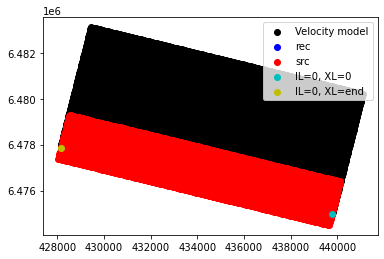

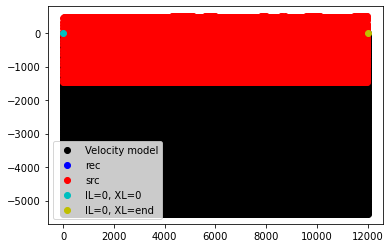

In [16]:
# Shot gather
sg = SegyShot(inputfile, components=['P', 'VZ', 'VX', 'VY'])
sg.interpret()
# sg.showgeometry()
sg.rotategeometry(velfile=velfile, plotflag=1)
# sg.showgeometry(local=True)

To simplify the problem and processing time, we take 30 adjacent sources and receivers separated by 200m. This uses the segyshot.py class provided in class, with very small alterations to src/rec selection. 

Sources X
 [9006.52034226 8806.38014413 8606.36167177 8405.97852439 8206.17755104
 8006.37657769 7806.86744483 7606.38726844 7406.48876377 7206.68753926
 7006.814736   6806.26172506 6606.33902593 6406.44127473 6206.30157891
 6006.37938209 5806.35990511 5606.34067929 5405.97946596 5206.12784327
 5006.25403538 4806.47826112 4605.5860254  4406.2197989  4205.64033309
 4005.91420354 3806.18958093 3606.34122328 3406.12718598 3206.20373338] 

Sources Y
 [-462.73877052 -462.35006699 -461.20957704 -461.4998254  -461.64490698
 -461.78998857 -460.6255553  -460.93999813 -461.93389514 -462.49128721
 -461.10835032 -461.54401661 -462.44088463 -462.19785019 -460.98452569
 -461.05677273 -461.56552472 -461.66196622 -465.76003796 -469.42185591
 -469.68816096 -468.28102961 -468.18291079 -471.31144594 -475.3608776
 -472.08625182 -466.33776313 -464.63954476 -466.02130665 -468.15510612] 

Receivers X
 [8996.03141451 8795.86576613 8595.53075651 8395.22019252 8194.86073728
 7994.69609353 7794.2401116  7593.978

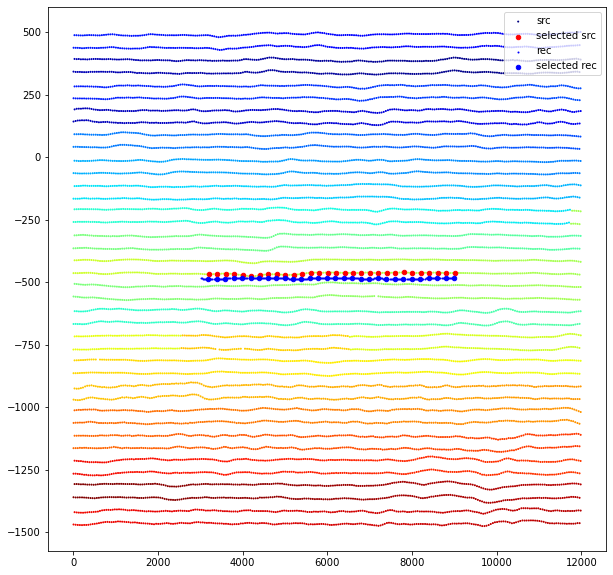

In [17]:
ishotc = 5398
sg.selectrecs()
# sg.selectsrcs()
sg.selectsrcs(ishotc, ishotc+240-2, plotflag=False)
# sg.showgeometry()
sg.showgeometry(local=True)


We plot the raw data for the first chosen source. The x axis is the index of each of the 30 receivers we picked, and y is time. Although the data is not corrected for 3D spreading in this plot, we do multiply the data by sqrt(t) in the helper functions above. 

(5000, 30)


(0.0, 29.0, 9.998, 0.0)

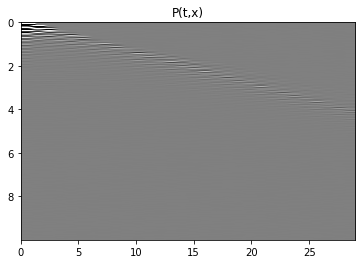

In [28]:
src_index = 0 #choose source
shot = sg.get_shotgather(ishotc+src_index)
shot_P = shot['P'].T[:, ::8]


drec = np.mean(np.abs(np.diff(sg.recx_local)))
offsetreg = np.arange(30)

vmax = 2e5
cmap = 'gray'
plt.imshow(shot_P, cmap=cmap, vmin=-vmax, vmax=vmax,
              extent = (offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]))

plt.title('P(t,x)')
plt.axis('tight')

Load and plot the velocity model. The commented axhline lines manually add horizontal lines at potential reflective surfaces (for demonstration purposes). Note that this is the in-line slice that roughly contains our 30 sources and receivers.  

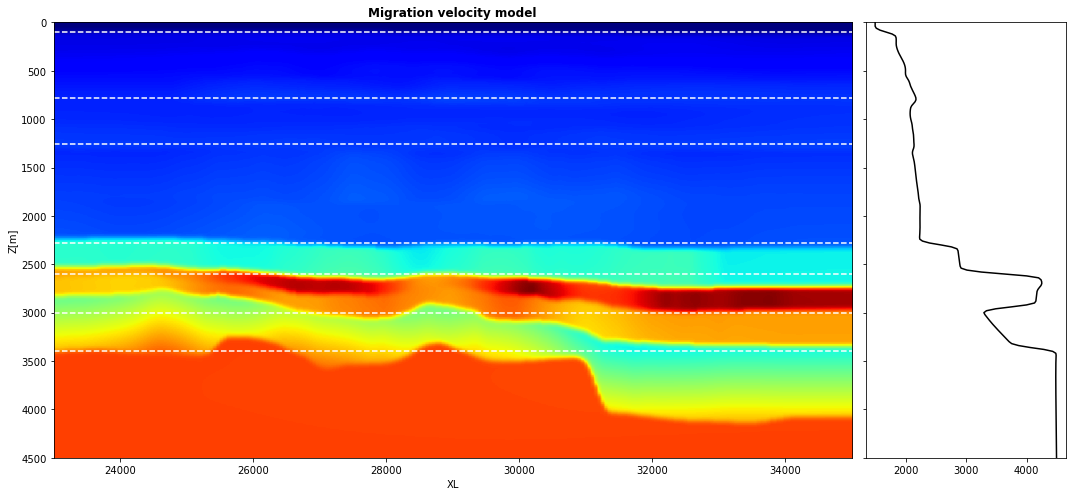

In [473]:

v_name = 'Velocities/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'
fv = sgi.open(v_name)
# print(sgi.tools.wrap(fv.text[0]),'\n')
# print(fv.bin,'\n')
# print(fv.header[0],'\n')



# Depth axes
z = fv.samples #0 to 4500, 20 increments, length 226
il, xl = fv.ilines*12.5, fv.xlines*12.5
x = xl

# Velocity model 
vmod = sgi.cube(v_name)


fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
axs[0].imshow(vmod[9].T, extent=(xl[0], xl[-1], z[-1], z[0]), cmap='jet')
# axs[0].axhline(z[5], color='w', linestyle='--')
# axs[0].axhline(z[39], color='w', linestyle='--')
# axs[0].axhline(z[63], color='w', linestyle='--')
# axs[0].axhline(z[114], color='w', linestyle='--')
# axs[0].axhline(z[130], color='w', linestyle='--')
# axs[0].axhline(z[150], color='w', linestyle='--')
# axs[0].axhline(z[170], color='w', linestyle='--')
axs[0].set_title('Migration velocity model', fontweight='bold')
axs[0].set_xlabel('XL')
axs[0].set_ylabel('Z[m]')
axs[0].axis('tight')
axs[1].plot(vmod[9, 120], z, 'k')
plt.tight_layout();


Raytrace one point and plot the traces to check. 

(226, 241) (241,) (226,) (1000,)
Ray tracing time per point 1.9423487186431885
Expected time to ray trace all points: (hrs) 29.386657030449975
Expected time to ray trace a depth (horizonal) layer: (s) 468.1060411930084
Expected time to ray trace a crossline (vertical) layer: (s) 438.9708104133606
Binning time per point 0.0007929801940917969
p_sum: 3155.091015625
sqrt t_time: 1.9849433241279208
new p_sum: 6262.676848480825
p_sum: 13673.784660980826
sqrt t_time: 1.972308292331602
new p_sum: 26968.918874409144
p_sum: 43992.98449940914
sqrt t_time: 1.9590814173994913
new p_sum: 86185.8384287363
p_sum: 89488.6146006113
sqrt t_time: 1.9462785001124583
new p_sum: 174169.7666020196
p_sum: 177069.7650395196
sqrt t_time: 1.9328735085359312
new p_sum: 342253.45800756925
p_sum: 347127.0669919443
sqrt t_time: 1.9193748982416126
new p_sum: 666266.9788845725
p_sum: 673422.9937283226
sqrt t_time: 1.9063053270659451
new p_sum: 1283749.8403129978
p_sum: 1289845.2075004978
sqrt t_time: 1.8926172354705006

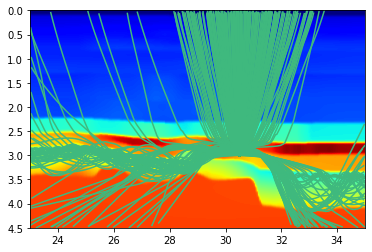

In [448]:

import time
dx,dz = 4*12.5,20 # 4 bins each 12.5m

vel2D = vmod[9].T #226,241 .. rows z, columns xl
slowness2D=1./vel2D
[dsdz,dsdx]=np.gradient(slowness2D,dz,dx)

lstep= np.linspace(0,1e5,1000)


ixs,izs = 150,150
source = [xl[ixs],z[izs]]

thetas = np.arange(-91,91,0.5)+180

plt.imshow(vel2D, extent=(xl[0]/1000,xl[-1]/1000,z[-1]/1000,z[0]/1000),cmap='jet')

rt_start = time.time()
output = raytrace(vel2D,xl,z,dx,dz,lstep,source,thetas,toplot=True)
rt_end = time.time()


print('Ray tracing time per point',rt_end-rt_start)
print('Expected time to ray trace all points: (hrs)', (rt_end-rt_start)*226*241/3600)
print('Expected time to ray trace a depth (horizonal) layer: (s)', (rt_end-rt_start)*241)
print('Expected time to ray trace a crossline (vertical) layer: (s)', (rt_end-rt_start)*226)
# print(output)

bin_start = time.time()
binned_t = bin_times(output,26100,32100,200)
bin_end = time.time()
print('Binning time per point',bin_end-bin_start)

p_sum = sum_point(binned_t,sg)
# plt.plot(t_times)


Now we iterate through the points in the velocity model, in steps of 4, for the sake of reducing time cost. This time we plot the depth migration without 3D spreading correction to compare with the next code block. 

In [ ]:
sums_h = []
for ixs in range(2,238,4):
    sums_v = []
    print("Starting a vertical layer")
    print(ixs)
    for izs in range(2,226,4):
        source = [xl[ixs],z[izs]]
        thetas = np.arange(-91,91,0.5)+180

        # rt_start = time.time()
        output = raytrace(vel2D,xl,z,dx,dz,lstep,source,thetas)
        # rt_end = time.time()


        # print('Ray tracing time per point',rt_end-rt_start)
        # print('Expected time to ray trace all points: (hrs)', (rt_end-rt_start)*226*241/3600)
        # print('Expected time to ray trace a depth (horizonal) layer: (s)', (rt_end-rt_start)*241)
        # print('Expected time to ray trace a crossline (vertical) layer: (s)', (rt_end-rt_start)*226)
        # print(output)

        # bin_start = time.time()
        binned_t = bin_times(output,26100,32100,200)
        # bin_end = time.time()
        # print('Binning time per point',bin_end-bin_start)
        p_sum = sum_point(binned_t,sg)
        sums_v.append(p_sum)
        
    sums_h.append(np.asarray(sums_v))
    
sums_h = np.asarray(sums_h)

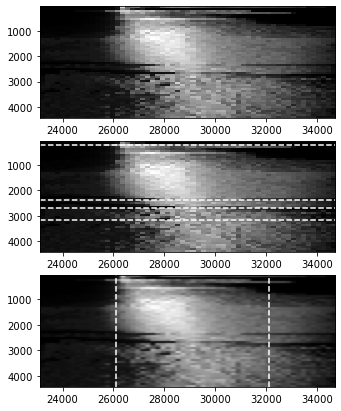

In [363]:
xax = np.arange(2,238,4)*50+23000
zax = np.arange(2,226,4)*20

fig, axs = plt.subplots(3, 1, figsize=(15, 7), sharey=True)
axs[0].imshow(sums_h.T, cmap='gray',extent = (xax[0], xax[-1], zax[-1], zax[0]))
axs[1].imshow(sums_h.T, cmap='gray',extent = (xax[0], xax[-1], zax[-1], zax[0]))
axs[1].axhline(zax[2], color='w', linestyle='--')
axs[1].axhline(zax[29], color='w', linestyle='--')
axs[1].axhline(zax[33], color='w', linestyle='--')
axs[1].axhline(zax[39], color='w', linestyle='--')
axs[2].imshow(sums_h.T, cmap='gray',extent = (xax[0], xax[-1], zax[-1], zax[0]))
axs[2].axvline(xax[15], color='w', linestyle='--')
axs[2].axvline(xax[45], color='w', linestyle='--')



This is the same code, ran again with 3D spreading correction to show the difference. 

Starting a vertical layer
2
Starting a vertical layer
6
Starting a vertical layer
10
Starting a vertical layer
14
Starting a vertical layer
18
Starting a vertical layer
22
Starting a vertical layer
26
Starting a vertical layer
30
Starting a vertical layer
34
Starting a vertical layer
38
Starting a vertical layer
42
Starting a vertical layer
46
Starting a vertical layer
50
Starting a vertical layer
54
Starting a vertical layer
58
Starting a vertical layer
62
Starting a vertical layer
66
Starting a vertical layer
70
Starting a vertical layer
74
Starting a vertical layer
78
Starting a vertical layer
82
Starting a vertical layer
86
Starting a vertical layer
90
Starting a vertical layer
94
Starting a vertical layer
98
Starting a vertical layer
102
Starting a vertical layer
106
Starting a vertical layer
110
Starting a vertical layer
114
Starting a vertical layer
118
Starting a vertical layer
122
Starting a vertical layer
126
Starting a vertical layer
130
Starting a vertical layer
134
Startin

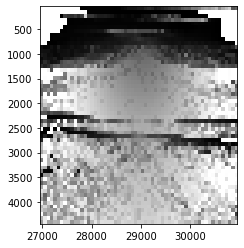

In [475]:
sums_h = []
for ixs in range(2,238,4):
    sums_v = []
    print("Starting a vertical layer")
    print(ixs)
    for izs in range(2,226,4):
        # izs = 5
        source = [xl[ixs],z[izs]]
        thetas = np.arange(-91,91,0.5)+180
        output = raytrace(vel2D,xl,z,dx,dz,lstep,source,thetas)
        binned_t = bin_times(output,26100,32100,200)
        p_sum = sum_point(binned_t,sg)
        sums_v.append(p_sum)
    sums_h.append(np.asarray(sums_v))
    
sums_h = np.asarray(sums_h)

plt.imshow(np.log(sums_h.T), cmap='gray',extent = (xax[0], xax[-1], zax[-1], zax[0]))#,vmin = 0,vmax = vm)

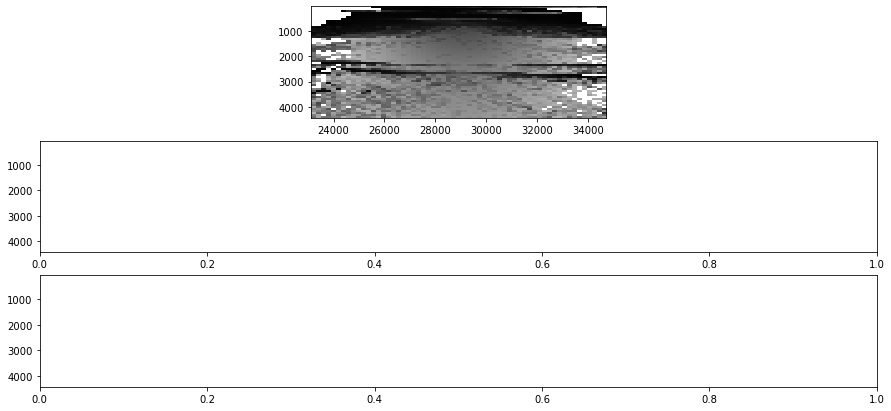

In [484]:
xax = np.arange(2,238,4)*50+23000
zax = np.arange(2,226,4)*20

fig, axs = plt.subplots(3, 1, figsize=(15, 7), sharey=True)
axs[0].imshow(np.log(sums_h.T), cmap='gray',extent = (xax[0], xax[-1], zax[-1], zax[0]))#,vmin = 0,vmax = vm)
# axs[1].imshow(sums_h.T, cmap='gray',extent = (xax[0], xax[-1], zax[-1], zax[0]))
# axs[1].axhline(zax[2], color='w', linestyle='--')
# axs[1].axhline(zax[29], color='w', linestyle='--')
# axs[1].axhline(zax[33], color='w', linestyle='--')
# axs[1].axhline(zax[39], color='w', linestyle='--')
# axs[2].imshow(sums_h.T, cmap='gray',extent = (xax[0], xax[-1], zax[-1], zax[0]))
# axs[2].axvline(xax[15], color='w', linestyle='--')
# axs[2].axvline(xax[45], color='w', linestyle='--')


In [ ]:
sums_h = []
for ixs in range(79,163,4):
    sums_v = []
    print("Starting a vertical layer")
    print(ixs)
    for izs in range(2,226,4):
        source = [xl[ixs],z[izs]]
        thetas = np.arange(-91,91,0.5)+180

        output = raytrace(vel2D,xl,z,dx,dz,lstep,source,thetas)
        binned_t = bin_times(output,26100,32100,200)
        p_sum = sum_point(binned_t,sg)
        sums_v.append(p_sum)
        
    sums_h.append(np.asarray(sums_v))
    
sums_h = np.asarray(sums_h)


xax = np.arange(79,163,4)*50+23000
zax = np.arange(2,226,4)*20



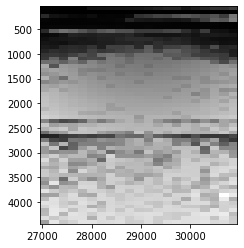

In [463]:
plt.imshow(np.log(sums_h.T), cmap='gray',extent = (xax[0], xax[-1], zax[-1], zax[0]))